In [1]:
import matplotlib.pyplot  as plt 
import matplotlib.patches as patches
from copy import deepcopy
import numpy as np
import pipe  as pp
import cv2 as cv
import glob
import os

from tqdm import tqdm
np.random.seed(0)
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
working_dir = os.path.abspath('') # os.path.dirname(os.path.realpath(__file__))
dataset_path = os.path.join(working_dir, "..", "dataset")

In [4]:
def imshow(img_bgr, ax=plt):
    nax = len(img_bgr.shape)
    if nax == 3:
      img_bgr = np.flip(img_bgr, axis=nax-1)
    ax.imshow(img_bgr)

In [5]:
def load_dataset(path):
    fl_img    = glob.glob(os.path.join(dataset_path, "images", "*.*"))
    fl_gtruth = glob.glob(os.path.join(dataset_path, "manual_vessel_mask", "*.*"))
    fl_mask   = glob.glob(os.path.join(dataset_path, "mask", "*.*"))
    loaded = []
    skipped = 0
    for p_img in tqdm(fl_img, desc="loading dataset"):
        name_img = os.path.basename(p_img).split(".")[0]
        gtruth_match = fl_gtruth | pp.filter(lambda s: os.path.basename(s).startswith(name_img))
        mask_match   = fl_mask   | pp.filter(lambda s: os.path.basename(s).startswith(name_img))

        img = cv.imread(p_img)
        try:
            gtruth = cv.imread(next(gtruth_match), cv.IMREAD_GRAYSCALE)
            mask   = cv.imread(next(mask_match),   cv.IMREAD_GRAYSCALE)
            loaded.append( (img, gtruth, mask) )
        except StopIteration:
            skipped += 1
            continue
    print(f"dataset is loaded, total: {len(fl_img)-skipped}, {skipped} images skipped")
    return loaded

        

In [6]:
dataset = load_dataset(dataset_path)

loading dataset: 100%|██████████| 45/45 [00:06<00:00,  7.01it/s]

dataset is loaded, total: 45, 0 images skipped


In [7]:
def random_sampling(dataset, shape, n_samples_image, min_shift):
    img_shape = dataset[0][0].shape
    def check_origin(origin, mask):
        if(origin[0]+shape[0] >= img_shape[0] or origin[1]+shape[1] >= img_shape[1]):
            return False
        partial_m = mask[origin[0] : (origin[0]+shape[0]), origin[1] : (origin[1]+shape[1])]
        if((partial_m == 0).sum() > 0):
            return False
        return True
    def slice_img(source, ii, jj):
        return source[ii:(ii+shape[0]), jj:(jj+shape[1])]
    
    img_res    = []
    gtruth_res = []
    meta_info  = []
    for idx, (img, gtruth, mask) in enumerate(tqdm(dataset, desc="sampling dataset")):
        n_done = 0
        while(n_done < n_samples_image):
            ii, jj = np.random.default_rng().integers(0, max(img_shape), 2)
            if not check_origin((ii, jj), mask):
                continue
            partial_img    = slice_img(img, ii, jj)
            partial_gtruth = slice_img(gtruth, ii, jj)
            partial_mask   = slice_img(mask, ii, jj)
            img_res.append(partial_img)
            gtruth_res.append(partial_gtruth)
            meta_info.append( (idx, ii, jj, ii+shape[0], jj+shape[1]) )

            n_done += 1
    return np.stack(img_res), np.stack(gtruth_res), np.stack(meta_info)
        
        

In [8]:
pshape = (256, 256)
piamges, pgtruth, meta = random_sampling(dataset, pshape, 10, 100)

sampling dataset: 100%|██████████| 45/45 [00:00<00:00, 542.24it/s]


In [9]:
np.save(f"../dataset/partial_images_{pshape[0]}_{pshape[1]}.npy", piamges, allow_pickle=False)
np.save(f"../dataset/partial_ground_truth_{pshape[0]}_{pshape[1]}.npy", pgtruth, allow_pickle=False)
np.save(f"../dataset/metadata_{pshape[0]}_{pshape[1]}.npy", meta, allow_pickle=False)

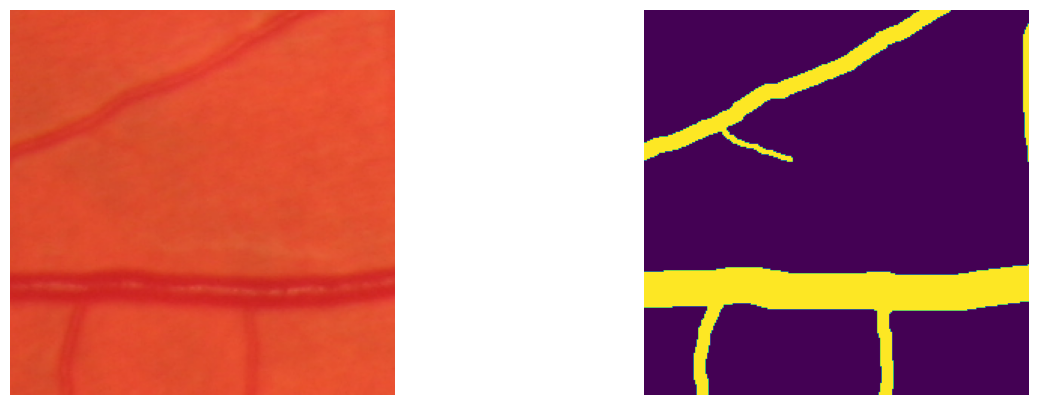

In [13]:
f, axarr = plt.subplots(1,2)
axarr[0].axis("off")
axarr[1].axis("off")
rint = np.random.randint(0, len(piamges))
imshow(piamges[rint], axarr[0])
imshow(pgtruth[rint], axarr[1])

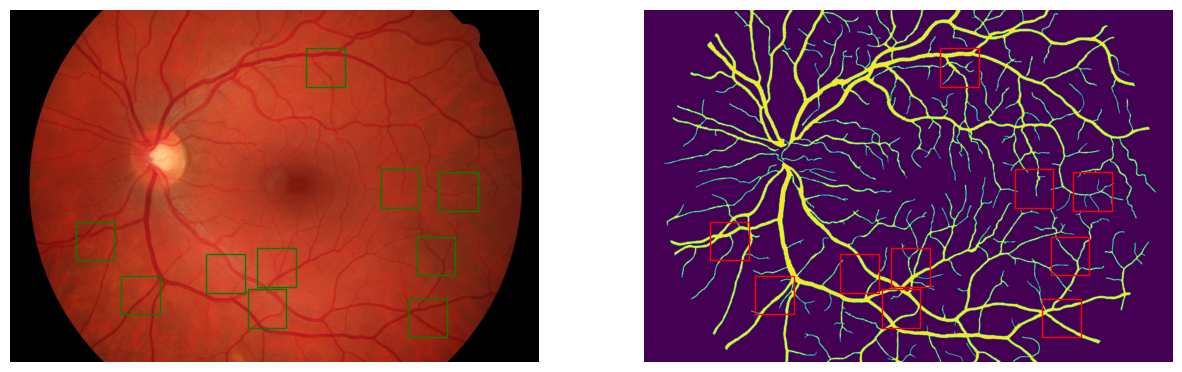

In [14]:
f, axarr = plt.subplots(1,2)
axarr[0].axis("off")
axarr[1].axis("off")
rint = np.random.randint(0, len(dataset))
imshow(dataset[rint][0], axarr[0])
imshow(dataset[rint][1], axarr[1])
for i, x, y, _, _ in meta:
    if i==rint:
        rect = patches.Rectangle((y, x), *pshape, linewidth=1, edgecolor='g', facecolor='none')
        axarr[0].add_patch(rect)
        rect = patches.Rectangle((y, x), *pshape, linewidth=1, edgecolor='r', facecolor='none')
        axarr[1].add_patch(rect)